# Sentiment Analysis using Python3 and Machine Learning

## Problem:

Companies are eager to know the sentiment of customers towards the products they sell or the services they provide, whether they are positive or negative.

Python sentiment analysis is a methodology for analyzing a string of text to discover the mood hidden within it. It accomplishes this by an amalgamation of machine learning and natural language processing (NLP). Sentiment analysis allows you to examine the feelings expressed in a piece of text.

Technology Used in This Project:
- Python3
- Pandas
- Matplotlib
- Tensorflow

## Solution

### Step 1: Data Wrangling and Processing

In [25]:
# import relevant modules
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [2]:
# create dataframe from data
data_frame = pd.read_csv('data_sets/Tweets.csv')

In [3]:
data_frame.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Only the text and sentiment colums are required. Rest of the data is irrelevant to this project.

In [4]:
reviewed_df = data_frame[['text','airline_sentiment']]

In [5]:
reviewed_df.shape

(14640, 2)

In [7]:
# preview the processed data to check
reviewed_df.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [9]:
# check the columns present
data_frame.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

Neutral sentiments are not required for this project. We shall omit them.

In [10]:
reviewed_df = reviewed_df[reviewed_df['airline_sentiment'] != 'neutral']

In [11]:
# check the shape
reviewed_df.shape

(11541, 2)

In [12]:
# preview again
reviewed_df.head(5)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [13]:
# check the values of airline sentiment column
reviewed_df['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

The labels for this dataset are categorical. Machines interpret only numeric data. Thus, we shall convert the categorical values to numeric ones using the `factorize()` method. This returns an array of numeric values and an index of categories.

In [14]:
sentiment_label = reviewed_df.airline_sentiment.factorize()

In [15]:
# preview what has been done
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

For clarification purposes, it must be stated that:
- `0` maps to postive sentiment
- `1` maps to negative sentiment

The data must be transformed into a form which the machine learning model understands.
The text needs to be converted into an array of vector embeddings. Word embeddings are a beautiful way of representing the relationship between the words in the text.

In [17]:
tweets = reviewed_df.text.values

In [18]:
tweets

array(["@VirginAmerica plus you've added commercials to the experience... tacky.",
       '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
       "@VirginAmerica and it's a really big bad thing about it", ...,
       '@AmericanAir thank you we got on a different flight to Chicago.',
       "@AmericanAir leaving over 20 minutes Late Flight. No warnings or communication until we were 15 minutes Late Flight. That's called shitty customer svc",
       "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"],
      dtype=object)

In [19]:
#instantiate the tokenizer

tokenizer = Tokenizer(num_words=5000)

In [20]:
tokenizer.fit_on_texts(tweets)

In [22]:
# replace words with assigned numbers
encoded_docs = tokenizer.texts_to_sequences(tweets)

In [24]:
# ensure all sentences are of equal length
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

### Step 2: Code the Text Classifier

Long Short Term Memory Networks (LSTM) layers have been used in this machine learning model. It is a variant of Recurrent Neural Networks. Recurrent Neural Networks are usually used with sequential data such as text and audio. Usually, while computing an embedding matrix, the meaning of every word and its calculations (which are called hidden states) are stored.

In [44]:
# define the vector length
embedding_vector_length = 32
# define the vocab_size var
vocab_size=13234

# instiate the sequential class
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# compile it
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 200, 32)           423488    
_________________________________________________________________
spatial_dropout1d_17 (Spatia (None, 200, 32)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                16600     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
_________________________________________________________________
None


### Step 3: Train the sentiment analysis model

Train the sentiment analysis model for 5 epochs on the whole dataset with a batch size of 32 and a validation split of 20%.

In [45]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=32)

2021-10-02 18:22:49.724531: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
289/289 [==============================] - 58s 191ms/step - loss: 0.3919 - accuracy: 0.8355 - val_loss: 0.2089 - val_accuracy: 0.9225
Epoch 2/5
289/289 [==============================] - 54s 185ms/step - loss: 0.2150 - accuracy: 0.9163 - val_loss: 0.1669 - val_accuracy: 0.9415
Epoch 3/5
289/289 [==============================] - 53s 185ms/step - loss: 0.1654 - accuracy: 0.9371 - val_loss: 0.1640 - val_accuracy: 0.9420
Epoch 4/5
289/289 [==============================] - 54s 185ms/step - loss: 0.1323 - accuracy: 0.9516 - val_loss: 0.1677 - val_accuracy: 0.9407
Epoch 5/5
289/289 [==============================] - 54s 186ms/step - loss: 0.1128 - accuracy: 0.9563 - val_loss: 0.1863 - val_accuracy: 0.9368


#### The python sentiment analysis model has obtained:
- 95.563% accuracy on the training set
- 93.68% accuracy on the training set

Since both are >90%, it can be assumed that the model is quite precise in its analysis.

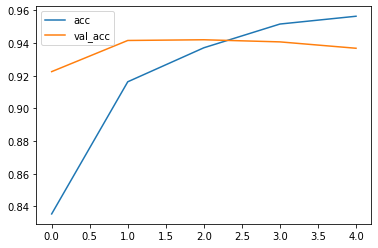

<Figure size 432x288 with 0 Axes>

In [46]:
# Plot the results as a graph
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

plt.savefig("Accuracy plot.jpg")

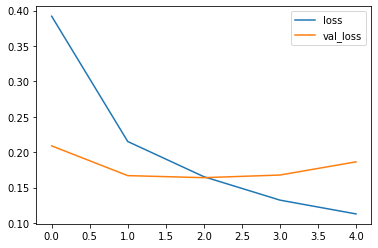

<Figure size 432x288 with 0 Axes>

In [47]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')

plt.legend()
plt.show()

plt.savefig("Loss plt.jpg")

#### Defining a function to test text input

In [48]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])

In [49]:
# test some samples out
test_sentence1 = "I have enjoyed my journey on this flight."
predict_sentiment(test_sentence1)

Predicted label:  positive


In [50]:
test_sentence2 = "This is the worst flight experience of my life!"
predict_sentiment(test_sentence2)

Predicted label:  negative


#### User Input Option:

In [51]:
test_str = input("Enter the Test String for Analysis: ")
predict_sentiment(test_str)

Enter the Test String for Analysis:  This flight was horrendously bad!!!


Predicted label:  negative


## Summary:

A python3 sentiment analysis model has been developed. In this machine learning project, a binary text classifier has been coded that classifies the sentiment of the tweets into positive and negative. More than 94% accuracy has been obtained on validation.

This project helps businesses across the domains to understand customers sentiment or feeling towards their brands.